In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import urllib
import datetime as dt

def buy_plot(df_market, df_operation):
    plt.figure(figsize=(12, 6))
    plt.plot(df_market.index, df_market['close'], label='Market Close Price', color='blue')
    # plt.scatter(df_operation.index, df_operation['Decision'], label='Buy Operations', color='green', marker='^')
    # if Decision == 1: buy, else if == -1: sell
    buy_operations = df_operation[df_operation['Decision'] == 1]
    sell_operations = df_operation[df_operation['Decision'] == -1]
    # mark at close price
    buy_operations['Decision'] = df_market.loc[buy_operations.index, 'close']
    sell_operations['Decision'] = df_market.loc[sell_operations.index, 'close']
    plt.scatter(buy_operations.index, buy_operations['Decision'], label='Buy Operations', color='green', marker='^')
    plt.scatter(sell_operations.index, sell_operations['Decision'], label='Sell Operations', color='red', marker='v')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Buy Operations on Market Close Price')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'./graphics/performance_comparison_{ticker}.pdf')
    plt.show()

def getStockMarketData(ticker, api_key = '4MFYSPOPV210V5WT'):
    if not os.path.exists(f'./data/stock_market_data-{ticker}.csv'):
        # ====================== Loading Data from Alpha Vantage ==================================


        # JSON file with all the stock market data for AAL from the last 20 years
        url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

        # Save data to this file
        file_to_save = './data/stock_market_data-%s.csv'%ticker

        # If you haven't already saved data,
        # Go ahead and grab the data from the url
        # And store date, low, high, volume, close, open values to a Pandas DataFrame
        if not os.path.exists(file_to_save):
            with urllib.request.urlopen(url_string) as url:
                data = json.loads(url.read().decode())
                # extract stock market data
                data = data['Time Series (Daily)']
                df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
                for k,v in data.items():
                    date = dt.datetime.strptime(k, '%Y-%m-%d')
                    data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                                float(v['4. close']),float(v['1. open'])]
                    df.loc[-1,:] = data_row
                    df.index = df.index + 1
            print('Data saved to : %s'%file_to_save)        
            df.to_csv(file_to_save)

    else:
        # If you have already saved data, just load it from the file
        df = pd.read_csv(f'./data/stock_market_data-{ticker}.csv', parse_dates=['timestamp'])
        df.set_index('timestamp', inplace=True)
    return df

def getOperation(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Operation file {file_path} does not exist.")
    
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    return df

def plot_performance_comparison(df_market, df_operation, ticker, slug):
    """
    Plot market vs strategy performance
    """
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Price and operations
    plt.subplot(3, 1, 1)
    plt.plot(df_market.index, df_market['close'], label='Market Close Price', color='blue', alpha=0.7)
    
    buy_operations = df_operation[df_operation['Decision'] == 1]
    sell_operations = df_operation[df_operation['Decision'] == -1]
    
    if not buy_operations.empty:
        plt.scatter(buy_operations.index, buy_operations['market_close'], 
                   label='Buy Operations', color='green', marker='^', s=100, zorder=5)
    if not sell_operations.empty:
        plt.scatter(sell_operations.index, sell_operations['market_close'], 
                   label='Sell Operations', color='red', marker='v', s=100, zorder=5)
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} - Trading Operations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Portfolio value and position
    plt.subplot(3, 1, 2)
    plt.plot(df_operation.index, df_operation['portfolio_value'], 
             label='Portfolio Value', color='purple', linewidth=2)
    plt.plot(df_operation.index, df_operation['cash'], 
             label='Cash', color='orange', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.title('Portfolio Components')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Cumulative returns comparison
    plt.subplot(3, 1, 3)
    
    # Align the market data to strategy dates for fair comparison
    strategy_dates = df_operation.index
    market_aligned = df_market.loc[df_market.index.isin(strategy_dates)]
    
    # Normalize both to start at 1 for comparison
    market_cumret = (1 + market_aligned['return_rate'].fillna(0)).cumprod()
    strategy_cumret = df_operation['cumulative_strategy_return']
    
    plt.plot(market_aligned.index, market_cumret, 
             label='Market Cumulative Return', color='blue', linewidth=2)
    plt.plot(df_operation.index, strategy_cumret, 
             label='Strategy Cumulative Return', color='red', linewidth=2)
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title(f'Cumulative Return Comparison: {ticker}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'./graphics/performance_comparison_{ticker}_{slug}.pdf')
    plt.show()
    
    # Print performance metrics
    final_market_return = market_cumret.iloc[-1] - 1
    final_strategy_return = strategy_cumret.iloc[-1] - 1
    
    print(f"\n=== Performance Summary ===")
    print(f"Market Return: {final_market_return:.2%}")
    print(f"Strategy Return: {final_strategy_return:.2%}")
    print(f"Outperformance: {final_strategy_return - final_market_return:.2%}")
    print(f"Final Portfolio Value: ${df_operation['portfolio_value'].iloc[-1]:,.2f}")
    print(f"Final Cash: ${df_operation['cash'].iloc[-1]:,.2f}")
    print(f"Final Position: {df_operation['total_position'].iloc[-1]:,.0f} shares")


def calculate_strategy_returns(df_market, df_operation):
    """
    Calculate strategy returns based on actual trading operations
    """
    # Ensure we have matching dates
    df_market = df_market.copy()
    df_operation = df_operation.copy()
    
    # Calculate daily market returns
    df_market['return_rate'] = df_market['close'].pct_change()
    
    # Add market close prices to operation dataframe
    df_operation['market_close'] = df_market.loc[df_operation.index, 'close']
    
    # Calculate position changes and portfolio value
    df_operation['position_change'] = 0  # Net position change (positive for buy, negative for sell)
    df_operation['cash_flow'] = 0  # Cash flow (negative for buy, positive for sell)
    df_operation['total_position'] = 0  # Total shares held
    df_operation['portfolio_value'] = 0  # Total portfolio value
    df_operation['cash'] = 100000  # Starting cash (adjust as needed)
    
    current_position = 0
    current_cash = 100000  # Starting cash
    
    for i, (date, row) in enumerate(df_operation.iterrows()):
        decision = row['Decision']
        hands = row['Hands']
        price = row['market_close']
        
        if decision == 1:  # Buy
            shares_bought = hands
            cost = shares_bought * price
            if current_cash >= cost:
                current_position += shares_bought
                current_cash -= cost
                df_operation.loc[date, 'position_change'] = shares_bought
                df_operation.loc[date, 'cash_flow'] = -cost
        
        elif decision == -1:  # Sell
            shares_sold = min(hands, current_position)  # This prevents going negative
            revenue = shares_sold * price
            current_position -= shares_sold
            current_cash += revenue
            df_operation.loc[date, 'position_change'] = -shares_sold
            df_operation.loc[date, 'cash_flow'] = revenue
        
        df_operation.loc[date, 'total_position'] = current_position
        df_operation.loc[date, 'cash'] = current_cash
        df_operation.loc[date, 'portfolio_value'] = current_cash + current_position * price
        
        # Debug print
        print(f"Date: {date}, Position: {current_position}, Cash: {current_cash:.2f}, Portfolio: {current_cash + current_position * price:.2f}")
    
    # Calculate daily returns for the strategy
    df_operation['strategy_return'] = df_operation['portfolio_value'].pct_change()
    
    # Calculate cumulative returns
    df_market['cumulative_return'] = (1 + df_market['return_rate'].fillna(0)).cumprod()
    df_operation['cumulative_strategy_return'] = (1 + df_operation['strategy_return'].fillna(0)).cumprod()
    
    return df_market, df_operation

# Helper function to validate and summarize results
def validate_strategy_results(df_market, df_operation):
    """
    Validate the strategy calculation results
    """
    print("=== Validation Summary ===")
    print(f"Market data period: {df_market.index.min()} to {df_market.index.max()}")
    print(f"Operation data period: {df_operation.index.min()} to {df_operation.index.max()}")
    print(f"Total trading days: {len(df_market)}")
    print(f"Days with operations: {len(df_operation[df_operation['Decision'] != 0])}")
    print(f"Buy operations: {len(df_operation[df_operation['Decision'] == 1])}")
    print(f"Sell operations: {len(df_operation[df_operation['Decision'] == -1])}")
    print(f"Starting portfolio value: ${df_operation['portfolio_value'].iloc[0]:,.2f}")
    print(f"Final portfolio value: ${df_operation['portfolio_value'].iloc[-1]:,.2f}")
    print(f"Final position: {df_operation['total_position'].iloc[-1]} shares")
    print(f"Final cash: ${df_operation['cash'].iloc[-1]:,.2f}")
    
    # Check for any issues
    issues = []
    if df_operation['portfolio_value'].isna().any():
        issues.append("NaN values in portfolio_value")
    if (df_operation['cash'] < 0).any():
        issues.append("Negative cash balance detected")
    if (df_operation['total_position'] < 0).any():
        issues.append("Negative position detected")
    
    if issues:
        print("\n⚠️  Issues found:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print("\n✅ No issues detected")
    
    return len(issues) == 0

def plot_performance_comparison_normalized(df_market, df_operation, ticker, slug):
    # [previous subplot code remains the same]
    
    # Subplot 3: Normalized cumulative returns comparison
    plt.subplot(3, 1, 3)
    
    # Use normalized returns for fair comparison
    strategy_dates = df_operation.index
    market_aligned = df_market.loc[df_market.index.isin(strategy_dates)]
    
    plt.plot(market_aligned.index, market_aligned['cumulative_return_normalized'], 
             label='Market Cumulative Return (Normalized)', color='blue', linewidth=2)
    plt.plot(df_operation.index, df_operation['cumulative_strategy_return_normalized'], 
             label='Strategy Cumulative Return (Normalized)', color='red', linewidth=2)
    
    plt.xlabel('Date')
    plt.ylabel('Normalized Cumulative Return')
    plt.title(f'Normalized Cumulative Return Comparison: {ticker}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()    
    plt.savefig(f'./graphics/performance_comparison_{ticker}_{slug}.pdf')
    plt.show()

def fill_missing_dates(df_market, df_operation):
    """
    Fill missing dates in df_operation with 0 Decision and 0 Hands
    """
    # Reindex df_operation to match df_market dates
    df_operation_filled = df_operation.reindex(df_market.index, fill_value=0)
    
    # Ensure the columns exist and have correct default values
    if 'Decision' not in df_operation_filled.columns:
        df_operation_filled['Decision'] = 0
    if 'Hands' not in df_operation_filled.columns:
        df_operation_filled['Hands'] = 0
    
    # Fill any NaN values with 0 for Decision and Hands columns
    df_operation_filled['Decision'] = df_operation_filled['Decision'].fillna(0)
    df_operation_filled['Hands'] = df_operation_filled['Hands'].fillna(0)
    
    return df_operation_filled

In [2]:

# Usage
result_files = ['results/my-new-workspace-57403627_DJIA.csv', 'results/my-new-workspace-14900171_DJIA.csv', 'results/my-new-workspace-57676427_DJIA.csv']
methods = ['SLEIPNIR', 'Rule-Based Strategy', 'RAG-Augmented LLM', 'FinRL Agent']

ticker = result_files[0].split('_')[-1].split('.')[0]  # Extract ticker from result file name
slug = [result_file.split('_')[-2].split('-')[-1] for result_file in result_files]
df_market = getStockMarketData(ticker)
df_operations = [getOperation(result_file) for result_file in result_files]

# Filter market data to match operation date range
date_range = pd.date_range(start=df_operations[0].index.min(), end=df_operations[0].index.max(), freq='B')
df_market = df_market[df_market.index.isin(date_range)]
df_operations = [fill_missing_dates(df_market, df_operation) for df_operation in df_operations]

print(df_market.describe())
print(df_operations[0].describe())
print(df_operations[0].tail())


               open          high           low         close  volume
count    252.000000    252.000000    252.000000    252.000000   263.0
mean   40323.128611  40323.128611  40323.128611  40323.128611     0.0
std     2053.077767   2053.077767   2053.077767   2053.077767     0.0
min    37266.670000  37266.670000  37266.670000  37266.670000     0.0
25%    38720.710000  38720.710000  38720.710000  38720.710000     0.0
50%    39562.480000  39562.480000  39562.480000  39562.480000     0.0
75%    42088.877500  42088.877500  42088.877500  42088.877500     0.0
max    45014.040000  45014.040000  45014.040000  45014.040000     0.0
        Decision       Hands
count  263.00000  263.000000
mean     0.00000    3.802281
std      0.08737   43.518782
min     -1.00000    0.000000
25%      0.00000    0.000000
50%      0.00000    0.000000
75%      0.00000    0.000000
max      1.00000  500.000000
            Decision  Hands
timestamp                  
2024-12-26         0      0
2024-12-27         0     

In [3]:

# Calculate returns with the improved method
mkt_opt = [calculate_strategy_returns(df_market, df_operation) for df_operation in df_operations]
validate_strategy_results(df_market, df_operations[0])
df_market, df_operations = mkt_opt[0][0], [op[1] for op in mkt_opt]


Date: 2024-01-01 00:00:00, Position: 0, Cash: 100000.00, Portfolio: nan
Date: 2024-01-02 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-03 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-04 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-05 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-08 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-09 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-10 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-11 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-12 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-15 00:00:00, Position: 0, Cash: 100000.00, Portfolio: nan
Date: 2024-01-16 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.00
Date: 2024-01-17 00:00:00, Position: 0, Cash: 100000.00, Portfolio: 100000.0

/tmp/ipykernel_406584/92264178.py:157: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_market['return_rate'] = df_market['close'].pct_change()
/tmp/ipykernel_406584/92264178.py:202: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_operation['strategy_return'] = df_operation['portfolio_value'].pct_change()
/tmp/ipykernel_406584/92264178.py:157: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_market[

KeyError: 'portfolio_value'

/tmp/ipykernel_401674/335713088.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_market['return_rate'] = df_market['close'].pct_change()
/tmp/ipykernel_401674/335713088.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df_operation['position'] = df_operation['Decision'].replace(0, method='ffill').fillna(0)
/tmp/ipykernel_401674/335713088.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_operation['strategy_return'] = df_operation['market_close'].pct_change() * df_operation['position'].shift(1).fillna(0)
/tmp/ipykernel_

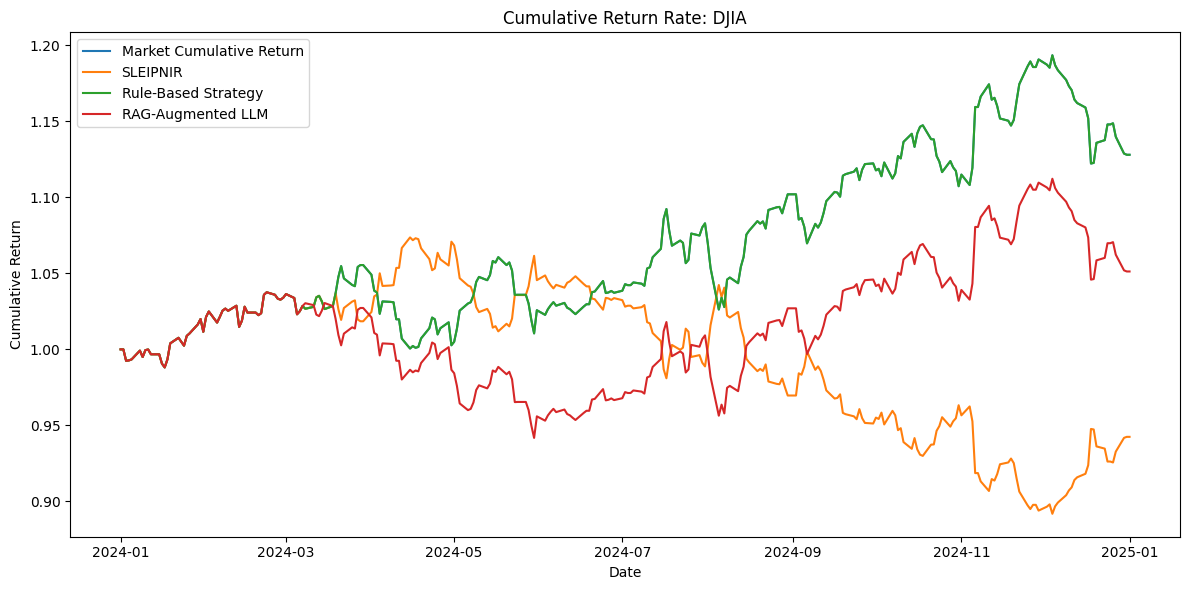

In [ ]:
# Calculate daily return rate for the market
df_market['return_rate'] = df_market['close'].pct_change()

for i, df_operation in enumerate(df_operations):
    # Calculate strategy return rate based on operations
    df_operation['market_close'] = df_market.loc[df_operation.index, 'close']
    df_operation['position'] = df_operation['Decision'].replace(0, method='ffill').fillna(0)
    df_operation['strategy_return'] = df_operation['market_close'].pct_change() * df_operation['position'].shift(1).fillna(0)

    # Cumulative returns
    df_market['cumulative_return'] = (1 + df_market['return_rate'].fillna(0)).cumprod()
    df_operation['cumulative_strategy_return'] = (1 + df_operation['strategy_return'].fillna(0)).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df_market.index, df_market['cumulative_return'], label='Market Cumulative Return')
# plt.plot(df_operation.index, df_operation['cumulative_strategy_return'], label='Strategy Cumulative Return')
for i, df_operation in enumerate(df_operations):
    plt.plot(df_operation.index, df_operation['cumulative_strategy_return'], label=methods[i])
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title(f'Cumulative Return Rate: {ticker}')
plt.legend()
# plt.xlim(df_operation.index.min(), df_operation.index.max())
plt.tight_layout()
plt.savefig(f'./graphics/Cumulative_Return_{ticker}_{slug}.pdf')
plt.show()
